# Setup

In [1]:
import json
import pprint
import numpy as np
from matplotlib import pyplot as plt
import os
from pathlib import Path
from utilities_network import data_dict_to_2d_array, data_dict_to_3d_array, scale_data_array
from utilities_network import get_time_networks, plot_time_networks
import utilities_visualization

class InterSystemRecurrenceNetwork(InteractingNetworks):

    """
    Generating and quantitatively analyzing inter-system recurrence networks.

    For a inter-system recurrence network, time series 


# Data

Active slice (here, [1300,2300]) of each quantity of each sensor.

- Inititally stored as a dictionary.
- First level: 5 sensors ('OR', 'OL', 'IB', 'IT', 'IL')
- Second level: 22 quantities ('time', 'ax', 'ay', 'az', 'phi', 'theta', 'psi', 'wx', 'wy', 'wz', 'phidot', 'thetadot', 'psidot', 'Ax', 'Ay', 'Az', 'dx', 'dy', 'dz', 'vx', 'vy', 'vz')

In [2]:
SCALE_DATA_OVERALL = True # whether to scale data array all at once (overall), or individually by time series

In [3]:
# Data was saved as a dictionary using experiment_save_data.py.
# To regenerate the data (use different experiment data or different active slice other than [1300-2300]),
# Go to experiments directory and run in python:
    # python experiment_save_data.py

with open("../../experiments/data_2025-09-03 Euler Angles_20250903_203926.json", 'r') as f:
    data_dict = json.load(f)

if SCALE_DATA_OVERALL:
    OUT_DIR = Path("network_time_plots/scaled_overall")
else:
    OUT_DIR = Path("network_time_plots/scaled_individually")
if not OUT_DIR.exists():
    os.makedirs(OUT_DIR)

In [4]:
print("Data Dictionary Structure:")
print(f"{pprint.pformat(data_dict, depth=2)[:210]}\n...")
print(f"{len(list(data_dict['OR'].keys()))} Quantities Included:")
print([data_dict['OR'].keys()])

Data Dictionary Structure:
{'IB': {'Ax': [...],
        'Ay': [...],
        'Az': [...],
        'ax': [...],
        'ay': [...],
        'az': [...],
        'dx': [...],
        'dy': [...],
        'dz': [...],
        'phi': [...],
...
22 Quantities Included:
[dict_keys(['time', 'ax', 'ay', 'az', 'phi', 'theta', 'psi', 'wx', 'wy', 'wz', 'phidot', 'thetadot', 'psidot', 'Ax', 'Ay', 'Az', 'dx', 'dy', 'dz', 'vx', 'vy', 'vz'])]


Use `data_dict_to_2d_array` and `data_dict_to_3d_array` to store the data as an array that is ready for `compute_functional_network`.

- The 3d array method allows each node to be a vector of multiple components (e.g., [dx,vx] or [wx,wy,wz]), so that phase space or multi-directional data can be used.

In [5]:
data = data_dict_to_2d_array(data_dict)
print(f"{data.shape=}")

data.shape=(1000, 15)


In [6]:
data_3d = data_dict_to_3d_array(data_dict)
print(f"{data_3d.shape=}")

data_3d.shape=(1000, 15, 2)


## Scale Data

- If one node has higher magnitudes in general, the distance measure will be dominated by the behavior of that node, effectively cancelling out the behavior of the other node.
- Use `scale_data_array` to make all time series scaled to have standard deviation 1 and mean 0.
- Two options: 
    1) `scale_overall`=`True`: Scale by the overall component values (ALL displacements, ALL velocities)
    2) `scale_overall`=`False`: Scale by the individual component values (displacement at femur, velocity at femur, etc.)

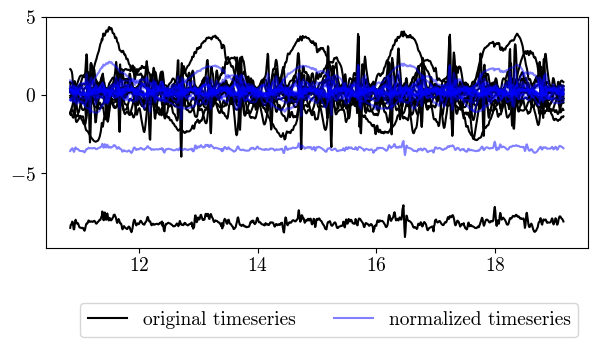

In [7]:
fig,ax = plt.subplots(figsize=(7,3))
og = ax.plot(data_dict['OR']['time'],data,color='k',label='original timeseries')
nm = ax.plot(data_dict['OR']['time'],scale_data_array(data,scale_overall=SCALE_DATA_OVERALL),color='b',alpha=0.5,label='normalized timeseries')
plt.setp(og[1:], label="_")
plt.setp(nm[1:], label="_")
ax.legend(ncols=2,bbox_to_anchor=(1,-0.2));

# Network Analysis

- hoop, tibia, cuneiform, femur ('OR', 'IT', 'IL', 'IB')

## List Parameters for Networks

In [8]:
# To compute new networks
COMPUTE_NEW = False
PLOT_NEW = True

In [9]:
# Number of timesteps to analyze (first `N_TIME` timesteps will be used)
N_TIME = 1000

network_parameters = {
    'angular_velocities': dict(
        sensors=['OR','IT','IL','IB'],
        quantities=[['wx'],['wy'],['wz']],
        width_scale=5.0
    ),
    'euler_phase_space': dict(
        sensors=['OR','IT','IL','IB'],
        quantities=[['phi','phidot'],['theta','thetadot'],['psi','psidot']],
        width_scale=7.0
    ),
    'linear_phase_space': dict(
        sensors=['OR','IT','IL','IB'],
        quantities=[['dx','vx'],['dy','vy'],['dz','vz']],
        width_scale=5.0
    ),
    'angular_velocity_3d': dict(
        sensors=['OR','IT','IL','IB'],
        quantities=[['wx', 'wy', 'wz']],
        width_scale=5.0
    ),
    'euler_angle_3d': dict(
        sensors=['OR','IT','IL','IB'],
        quantities=[['phi', 'theta', 'psi']],
        width_scale=5.0
    ),
    'linear_displ_3d': dict(
        sensors=['OR','IT','IL','IB'],
        quantities=[['dx', 'dy', 'dz']],
        width_scale=5.0
    ),
}

In [10]:
# For storing results
network_windows = {}
mappings = {}
target_node_lists = {}

sensor_name_mapping = {
    'OR': 'h',
    'IB': 'f',
    'IT': 't',
    'IL': 'c'
}

quantity_name_mapping = {
    'wx': r"$\omega_{x}$",
    'wy': r"$\omega_{y}$",
    'wz': r"$\omega_{z}$",
    'dx': r"$d_{x}$",
    'dy': r"$d_{y}$",
    'dz': r"$d_{z}$",
    'vx': r"$v_{x}$",
    'vy': r"$v_{y}$",
    'vz': r"$v_{z}$",
    'phi': r"$\phi$",
    'theta': r"$\theta$",
    'psi': r"$\psi$",
    'phidot': r"$\dot{\phi}$",
    'thetadot': r"$\dot{\theta}$",
    'psidot': r"$\dot{\psi}$",
}

def get_mappings(**config):
    sensors = config['sensors']
    quantities = config['quantities']
    nq = len(quantities)
    mapping = {
        nq*i+j: f"{sensor_name_mapping[s]}{quantity_name_mapping[q[0]]}"
        for i,s in enumerate(sensors)
        for j,q in enumerate(quantities)
    }
    return mapping

def get_target_nodes(**config):
    quantities = config['quantities']
    target_nodes = [f"{sensor_name_mapping['OR']}{quantity_name_mapping[q[0]]}"
        for q in quantities
    ]
    return target_nodes

for title,parameters in network_parameters.items():
    mappings[title] = get_mappings(**parameters)
    target_node_lists[title] = get_target_nodes(**parameters)

## Plot Time Histories of Network Quantities

In [11]:
if COMPUTE_NEW:
    for title,parameters in network_parameters.items():
        sensors = parameters['sensors']
        quantities = parameters['quantities']
        data = scale_data_array(data_dict_to_3d_array(data_dict,
                                    sensors=sensors,
                                    quantities=quantities,
                                    ntime=parameters.get('ntime',N_TIME)),
                                scale_overall=SCALE_DATA_OVERALL
                                )
        network_windows[title] = get_time_networks(data,
                                                rr=parameters.get('rr',(0.06,0.06,0.02)),
                                                C_threshold=parameters.get('C_threshold',0.02),
                                                T_threshold=parameters.get('T_threshold',0.02))
        
    np.savez(OUT_DIR/'network_windows.npz', network_windows=network_windows)
    
else:
    network_windows = np.load(OUT_DIR/'network_windows.npz',allow_pickle=True)['network_windows'].item()

In [12]:
if PLOT_NEW:
    for title,parameters in network_parameters.items():
        plot_time_networks(network_windows[title],
                            mappings[title],
                            target_node_lists[title],
                            # width_scale = parameters.get('width_scale', 5.0),
                            width_scale = 5.0,
                            time=data_dict['OR']['time'],
                            plot_filename_prefix=OUT_DIR/title,
                            return_figs=True)

Saving network_time_plots/scaled_overall/angular_velocities/to_hoop/cunei_C_xys.png
Saving network_time_plots/scaled_overall/angular_velocities/to_hoop/cunei_T_xys.png
Saving network_time_plots/scaled_overall/angular_velocities/to_hoop/femur_C_xys.png
Saving network_time_plots/scaled_overall/angular_velocities/to_hoop/femur_T_xys.png
Saving network_time_plots/scaled_overall/angular_velocities/to_hoop/tibia_C_xys.png
Saving network_time_plots/scaled_overall/angular_velocities/to_hoop/tibia_T_xys.png
Saving network_time_plots/scaled_overall/angular_velocities/from_hoop/cunei_C_xys.png
Saving network_time_plots/scaled_overall/angular_velocities/from_hoop/cunei_T_xys.png
Saving network_time_plots/scaled_overall/angular_velocities/from_hoop/femur_C_xys.png
Saving network_time_plots/scaled_overall/angular_velocities/from_hoop/femur_T_xys.png
Saving network_time_plots/scaled_overall/angular_velocities/from_hoop/tibia_C_xys.png
Saving network_time_plots/scaled_overall/angular_velocities/from_h